<a href="https://colab.research.google.com/github/shivkumarganesh/Deep-Learning-Course/blob/main/Assignment-6/Part_B_Keras_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Updating the PIP

In [ ]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

# Utils functions for creating graphs

In [ ]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])

  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])

  plt.show()

# Keras Multiple Image Classification

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
from google.colab import files
print(tf.__version__)

2.4.1


## Importing data from Kaggle

In [ ]:
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Downloading the data

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 intel-image-classification	 'kaggle (1).json'   model.png
 intel-image-classification.zip   kaggle.json	     sample_data


### Unzipping the images

In [ ]:
zf = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(zf, 'r')
zip_ref.extractall('/content/intel-image-classification')
zip_ref.close()

In [ ]:
!ls /content/intel-image-classification/seg_test

seg_test


### Importing data for the training and validation set.

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/intel-image-classification/seg_train/seg_train/',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/intel-image-classification/seg_test/seg_test/',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


### Inspecting various images

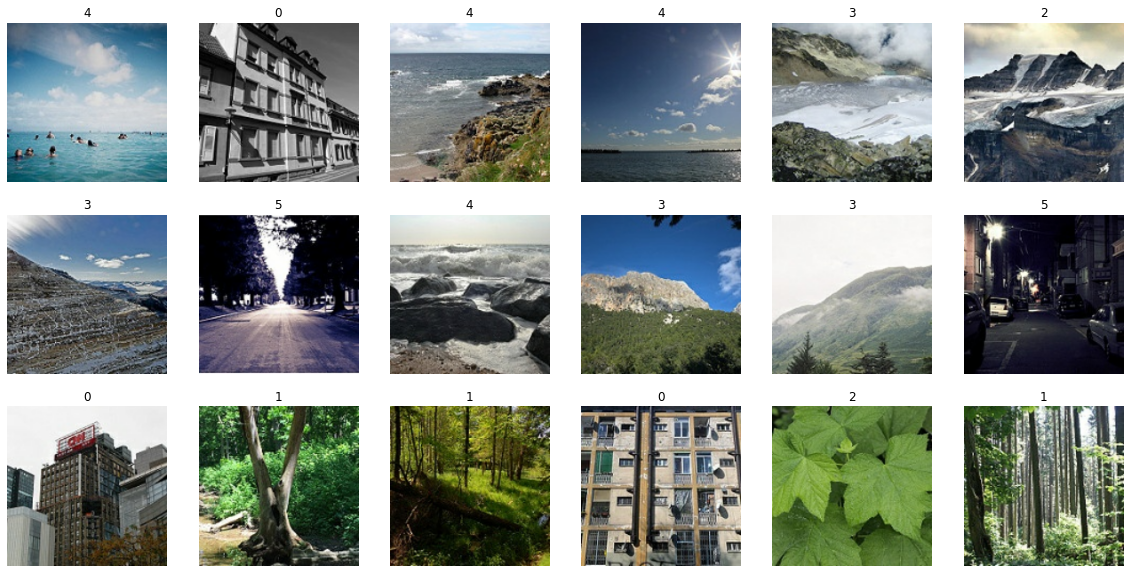

In [ ]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

### Transforming the images

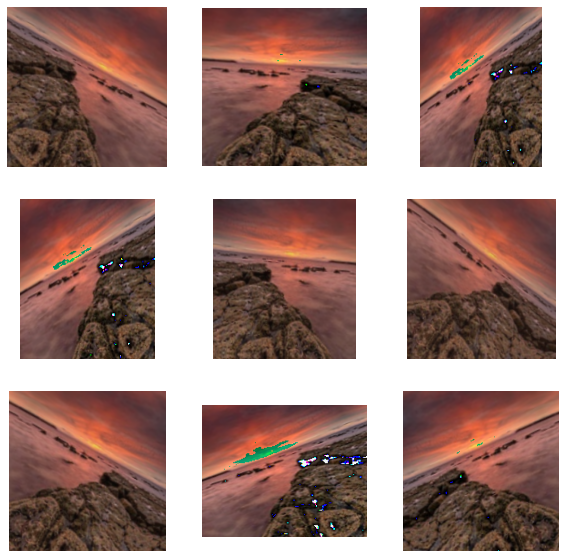

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomContrast(factor=0.2),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomHeight(factor=0.2),
        layers.experimental.preprocessing.RandomWidth(factor=0.2)
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

## Model description and construction

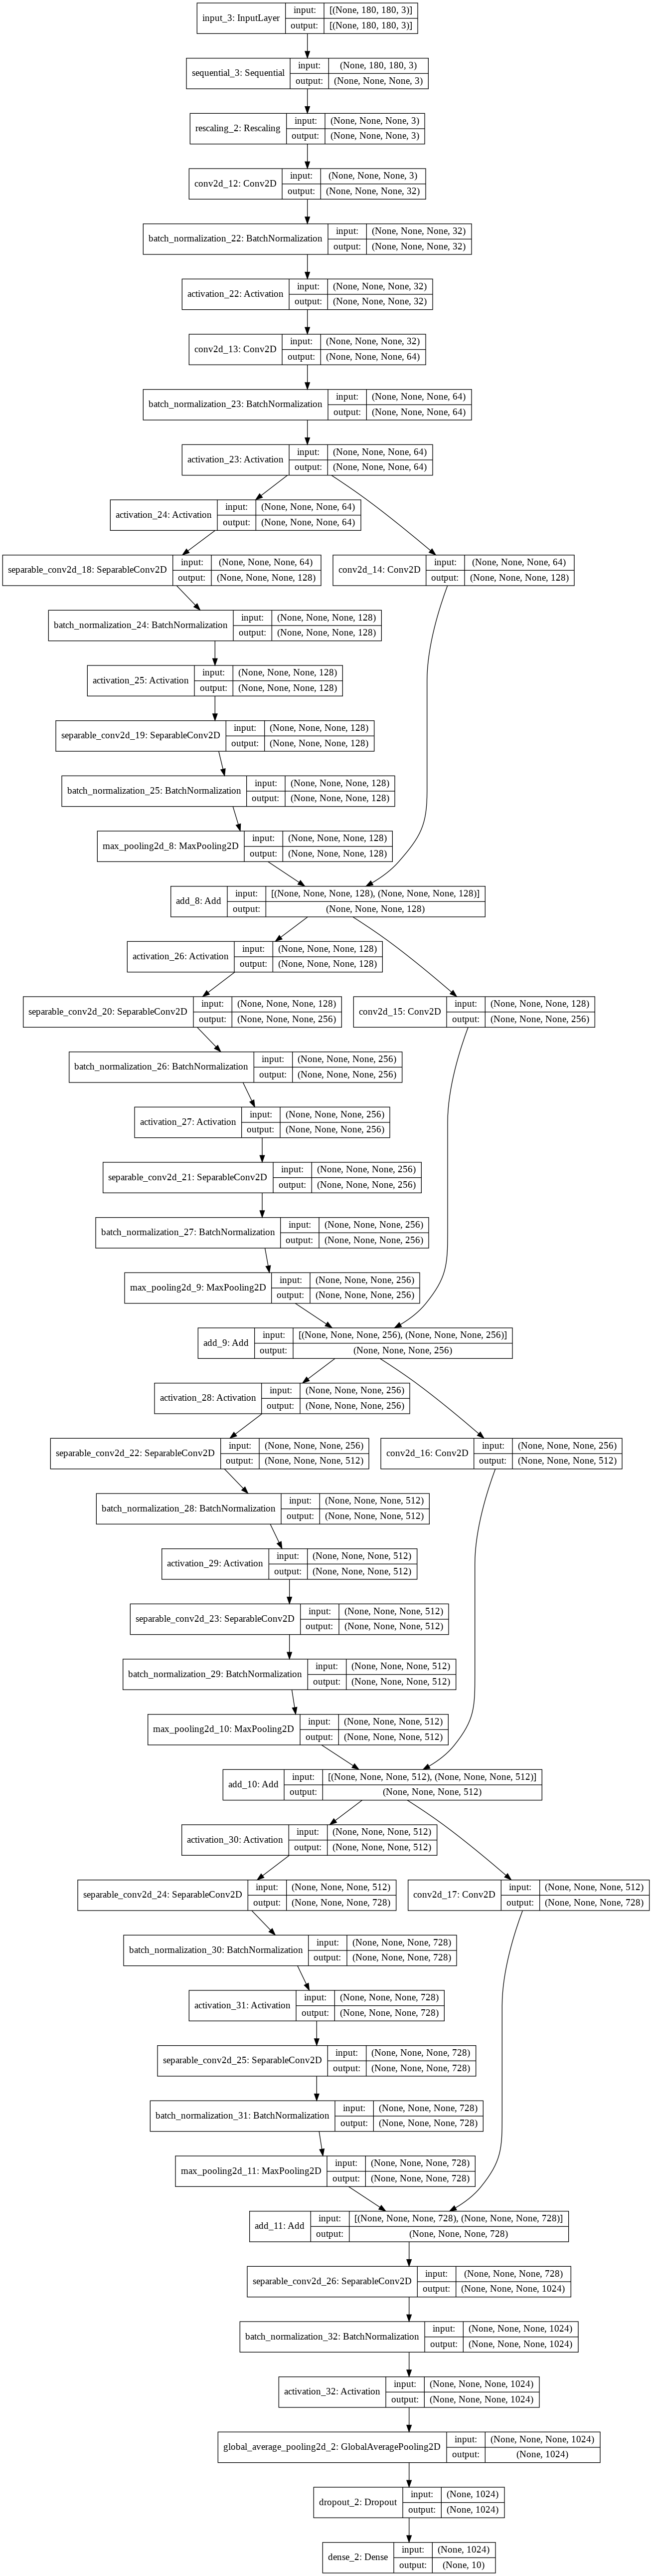

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model, show_shapes=True)


### Running the model

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
351/351 [==============================] - 2265s 6s/step - loss: 1.2332 - sparse_categorical_accuracy: 0.5340 - val_loss: 3.2590 - val_sparse_categorical_accuracy: 0.2383
Epoch 2/10
351/351 [==============================] - 2242s 6s/step - loss: 0.7966 - sparse_categorical_accuracy: 0.7064 - val_loss: 1.5421 - val_sparse_categorical_accuracy: 0.5850
Epoch 3/10
351/351 [==============================] - 2204s 6s/step - loss: 0.6836 - sparse_categorical_accuracy: 0.7572 - val_loss: 2.3066 - val_sparse_categorical_accuracy: 0.5133
Epoch 4/10
351/351 [==============================] - 2168s 6s/step - loss: 0.6083 - sparse_categorical_accuracy: 0.7829 - val_loss: 2.7830 - val_sparse_categorical_accuracy: 0.4750
Epoch 5/10
351/351 [==============================] - 2135s 6s/step - loss: 0.5672 - sparse_categorical_accuracy: 0.7985 - val_loss: 1.1062 - val_sparse_categorical_accuracy: 0.7150
Epoch 6/10
351/351 [==============================] - 2123s 6s/step - loss: 0.5385 - spars

# Plotting loss and accuracy

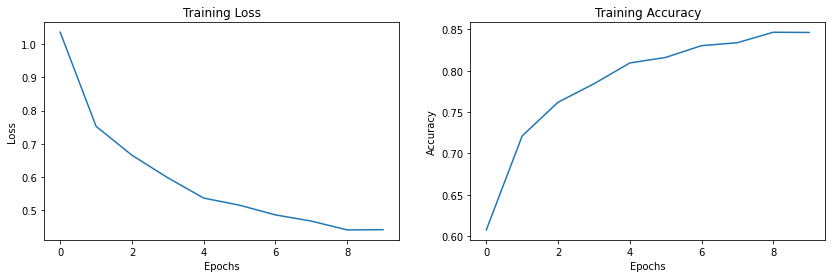

In [ ]:
# Training
plot(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )